# 蝴蝶图像识别分类



## 蝴蝶识别分类任务概述

人工智能技术的应用领域日趋广泛，新的智能应用层出不穷。本项目将利用人工智能技术来对蝴蝶图像进行分类，需要能对蝴蝶的类别、属性进行细粒度的识别分类。相关研究工作者能够根据采集到的蝴蝶图片，快速识别图中蝴蝶的种类。期望能够有助于提升蝴蝶识别工作的效率和精度。

## 作业要求

补充构建模型用于训练模块，搭建一个适合的模型用于训练，并且得到一个好的效果。


## 评分方式
1、补充模型并跑通 得60分
2、模型评估结果越高得分越高

### 解压数据集

In [1]:
!cd data &&\
unzip -qo data73998/Butterfly20_test.zip &&\
unzip -qo data73998/Butterfly20.zip &&\
rm -r __MACOSX

In [2]:
import paddle
import matplotlib.pyplot as plt
import PIL.Image as Image
import numpy as np
import matplotlib.pyplot as plt 
import cv2
import os 
import glob
import random
import time
import pandas as pd


print(paddle.__version__)


/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/paddle/fluid/layers/utils.py:26: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  def convert_to_list(value, n, name, dtype=np.int):
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/__init__.py:107: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import MutableMapping
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matp

2.0.2


### 查看图片数量


In [3]:
data_path='/home/aistudio/data/Butterfly20/*/*.jpg'
but_files =glob.glob(data_path)

print(f'图片数据为{len(but_files)}')

图片数据为1866


### 随机查看蝴蝶照片

/home/aistudio/data/Butterfly20/012.Losaria_coon/059.jpg
(600, 407, 3)
该样本标签为:012.Losaria_coon


/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:2349: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  if isinstance(obj, collections.Iterator):
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:2366: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  return list(data) if isinstance(data, collections.MappingView) else data


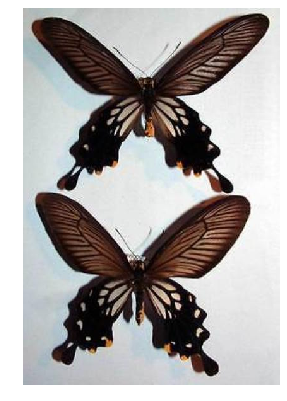

In [4]:
#随机显示一个样品的图片

index=random.choice(but_files)  # 随机获取一个地址
print(index)  # 查看地址
name=index.split('/')[-2]  # 获取标签
img = Image.open(index)  # 打开图片
img =cv2.imread(index)  # 图片处理
print(img.shape)  # 输出图片形状
img =img[:,:,::-1]  
print(f'该样本标签为:{name}')
plt.figure(figsize=(8,10),dpi=50)  # 修改显示的图像大小
plt.axis('off')
plt.imshow(img)             #根据数组绘制图像

##  准备数据

数据准备过程包括以下两个重点步骤：

一是建立样本数据读取路径与样本标签之间的关系。

二是构造读取器与数据预处理。可以写个自定义数据读取器，它继承于PaddlePaddle2.0的dataset类，在__getitem__方法中把自定义的预处理方法加载进去。

In [5]:
### 查看数据类型
data_list = [] #用个列表保存每个样本的读取路径、标签

# 由于属种名称本身是字符串，而输入模型的是数字。需要构造一个字典，把某个数字代表该属种名称。键是属种名称，值是整数。
label_list=[]
with open("/home/aistudio/data/species.txt") as f:
    for line in f:
        a,b = line.strip("\n").split(" ")
        label_list.append([b, int(a)-1])
label_dic = dict(label_list)
for i in label_dic:
    print(i)

001.Atrophaneura_horishanus
002.Atrophaneura_varuna
003.Byasa_alcinous
004.Byasa_dasarada
005.Byasa_polyeuctes
006.Graphium_agamemnon
007.Graphium_cloanthus
008.Graphium_sarpedon
009.Iphiclides_podalirius
010.Lamproptera_curius
011.Lamproptera_meges
012.Losaria_coon
013.Meandrusa_payeni
014.Meandrusa_sciron
015.Pachliopta_aristolochiae
016.Papilio_alcmenor
017.Papilio_arcturus
018.Papilio_bianor
019.Papilio_dialis
020.Papilio_hermosanus


## 创建训练集和验证集

In [6]:
butterfly_path = 'data/Butterfly20/'

if(os.path.exists('./train_set.txt')):  # 判断有误文件
    os.remove('./train_set.txt')  # 删除文件
if(os.path.exists('./validation_set.txt')):
    os.remove('./validation_set.txt')

data_list = []

for i in os.listdir(butterfly_path):
    if i not in '.DS_Store':
        for j in os.listdir(os.path.join(butterfly_path, i)):
            data_list.append(f'{os.path.join(butterfly_path, i, j)}\t{label_dic[i]}\n')

random.shuffle(data_list)  # 乱序
print(data_list[0])
data_len = len(data_list)
count = 0
for data in data_list:
    if count <= data_len*0.8:
        with open('./train_set.txt', 'a')as f:
            f.write(data)
            count += 1
    else:
        with open('./validation_set.txt', 'a')as tf:  # 80%写入训练集
            tf.write(data)
            count += 1

data/Butterfly20/006.Graphium_agamemnon/061.jpg	5



### 使用了Paddle.dataset对数据进行自定义读取


In [7]:
#以下代码用于构造读取器与数据预处理
#首先需要导入相关的模块
import paddle
from paddle.vision.transforms import Compose,CenterCrop, Resize,Normalize,RandomRotation,RandomHorizontalFlip,Transpose,ToTensor
import cv2
import numpy as np
from PIL import Image
from paddle.io import Dataset

# 自定义数据读取器
class Reader(Dataset):
    def __init__(self, mode='train_set'):
        """
        初始化函数
        """
        self.data = []
        with open(f'{mode}_set.txt') as f:
            for line in f.readlines():
                info = line.strip().split('\t')
                if len(info) > 0:
                    self.data.append([info[0].strip(), info[1].strip()])  
                      
    def __getitem__(self, index):
        """
        读取图片，对图片进行归一化处理，返回图片和 标签
        """
        image_file, label = self.data[index]  # 获取数据
        img = Image.open(image_file)  # 读取图片
        img = img.convert('RGB')
        img = img.resize((224, 224), Image.ANTIALIAS)  # 图片大小样式归一化
        img = np.array(img).astype('float32')  # 转换成数组类型浮点型32位
        img = img.transpose((2, 0, 1))     #读出来的图像是rgb,rgb,rbg..., 转置为 rrr...,ggg...,bbb...
        img = img/255.0  # 数据缩放到0-1的范围
        # img = img.shape()
        # print(img(0:3,:,:))
        return img, np.array(label, dtype='int64')

    def __len__(self):
        """
        获取样本总数
        """
        return len(self.data)

# 训练的数据提供器
train_dataset = Reader(mode='train')
# 测试的数据提供器
eval_dataset = Reader(mode='validation')

# 查看训练和测试数据的大小
print('train大小：', train_dataset.__len__())
print('eval大小：', eval_dataset.__len__())

# 查看图片数据、大小及标签
for data, label in eval_dataset:
    print(data)
    print(np.array(data).shape)
    print(label)
    break

train大小： 1493
eval大小： 373
[[[0.1254902  0.12941177 0.14509805 ... 0.28627452 0.30980393 0.38431373]
  [0.13333334 0.14117648 0.15294118 ... 0.34117648 0.37254903 0.44313726]
  [0.13333334 0.14117648 0.15294118 ... 0.40392157 0.44313726 0.5058824 ]
  ...
  [0.14509805 0.1764706  0.2509804  ... 0.16078432 0.15294118 0.21568628]
  [0.2        0.22745098 0.28627452 ... 0.19607843 0.18431373 0.21176471]
  [0.21960784 0.23921569 0.29411766 ... 0.21176471 0.18039216 0.18431373]]

 [[0.21568628 0.21960784 0.23529412 ... 0.42352942 0.43529412 0.5058824 ]
  [0.21960784 0.22745098 0.23921569 ... 0.48235294 0.5019608  0.56078434]
  [0.21568628 0.22745098 0.23921569 ... 0.5372549  0.5686275  0.62352943]
  ...
  [0.25490198 0.28627452 0.37254903 ... 0.2509804  0.23921569 0.29803923]
  [0.32156864 0.3529412  0.42352942 ... 0.2901961  0.27450982 0.29411766]
  [0.34509805 0.3647059  0.42745098 ... 0.30588236 0.27058825 0.26666668]]

 [[0.04313726 0.05490196 0.07450981 ... 0.         0.04705882 0.176470

## 建立模型



#  构建模型用于训练

In [14]:
#定义模型
import paddle
from paddle.vision.transforms import Compose,CenterCrop, Resize,Normalize,RandomRotation,RandomHorizontalFlip,Transpose,ToTensor
import cv2
import numpy as np
from PIL import Image
from paddle.io import Dataset

class MyCNN(paddle.nn.Layer):

    def __init__(self):
        super(MyCNN,self).__init__()
        self.layer = paddle.vision.models.resnet152(pretrained = True)##
        self.fc1 = paddle.nn.Linear(1000,512)
        self.fc2 = paddle.nn.Linear(512,20)
        self.flatten = paddle.nn.Flatten()# 展平
        self.relu = paddle.nn.ReLU()
        self.dropout = paddle.nn.Dropout(0.2)
    

    def forward(self,x):
        x=self.layer(x)
        x=self.flatten(x)
        x=self.fc1(x)
        x=self.relu(x)
        x=self.dropout(x)
        x=self.fc2(x)
        return x

### 实例化模型并可视化

In [15]:
#定义输入
input_def = paddle.static.InputSpec(shape=[-1,3,224,224], dtype="float32", name="img")
label_def = paddle.static.InputSpec(shape=[-1,1], dtype="int64", name="label")

#实例化网络对象并定义优化器等训练逻辑
model = MyCNN()
model = paddle.Model(model,inputs=input_def,labels=label_def) #用Paddle.Model()对模型进行封装


# model.summary((1,3, 224, 224))
visualdl = paddle.callbacks.VisualDL(log_dir='visualdl_log')   

2022-08-20 10:38:03,846 - INFO - unique_endpoints {''}
2022-08-20 10:38:03,847 - INFO - File /home/aistudio/.cache/paddle/hapi/weights/resnet152.pdparams md5 checking...
2022-08-20 10:38:04,655 - INFO - Found /home/aistudio/.cache/paddle/hapi/weights/resnet152.pdparams


In [16]:

# 配置优化器、损失函数、评估指标
model.prepare(paddle.optimizer.Adam(learning_rate=0.0001, parameters=model.parameters()), 
              paddle.nn.CrossEntropyLoss(), 
              paddle.metric.Accuracy())

# 训练可视化VisualDL工具的回调函数
visualdl = paddle.callbacks.VisualDL(log_dir='visualdl_log')   

# 启动模型全流程训练
model.fit(train_dataset,  # 训练数据集
          eval_dataset,   # 评估数据集
          epochs=10,       # 训练的总轮次
          batch_size=32,  # 训练使用的批大小
          verbose=1,      # 日志展示形式
          callbacks=[visualdl])  # 设置可视化

The loss value printed in the log is the current step, and the metric is the average value of previous step.
Epoch 1/10
step 47/47 [==============================] - loss: 0.7378 - acc: 0.5070 - 340ms/step        
Eval begin...
The loss value printed in the log is the current batch, and the metric is the average value of previous step.
step 12/12 [==============================] - loss: 0.8528 - acc: 0.7507 - 300ms/step         
Eval samples: 373
Epoch 2/10
step 47/47 [==============================] - loss: 0.2559 - acc: 0.8848 - 332ms/step        
Eval begin...
The loss value printed in the log is the current batch, and the metric is the average value of previous step.
step 12/12 [==============================] - loss: 1.0635 - acc: 0.8525 - 293ms/step         
Eval samples: 373
Epoch 3/10
step 47/47 [==============================] - loss: 0.5046 - acc: 0.9625 - 331ms/step        
Eval begin...
The loss value printed in the log is the current batch, and the metric is the average va

## 模型评估

In [17]:
result = model.evaluate(eval_dataset, verbose=1)
print(result)

Eval begin...
The loss value printed in the log is the current batch, and the metric is the average value of previous step.
step 373/373 [==============================] - loss: 0.2713 - acc: 0.8445 - 82ms/step            
Eval samples: 373
{'loss': [0.2713069], 'acc': 0.8445040214477212}


## 保存模型

In [18]:
model.save('./butterfly')  # 保存模型

## 进行预测

In [19]:
def load_image(file):
        # 打开图片
        im = Image.open(file)
        # 将图片调整为跟训练数据一样的大小
        im = im.convert('RGB')
        im = im.resize((224, 224), Image.ANTIALIAS)
        # 建立图片矩阵 类型为float32
        im = np.array(im).astype(np.float32)
        # 矩阵转置 
        im = im.transpose((2, 0, 1))                               
        # 将像素值从[0-255]转换为[0-1]
        im = im / 255.0
        # print(im)       
        im = np.expand_dims(im, axis=0)
        # 保持和之前输入image维度一致
        print('im_shape的维度：',im.shape)
        return im

2022-08-20 10:43:18,351 - INFO - unique_endpoints {''}
2022-08-20 10:43:18,352 - INFO - File /home/aistudio/.cache/paddle/hapi/weights/resnet152.pdparams md5 checking...
2022-08-20 10:43:19,150 - INFO - Found /home/aistudio/.cache/paddle/hapi/weights/resnet152.pdparams


im_shape的维度： (1, 3, 224, 224)
[1, 3, 224, 224]
预测的结果为: 012.Losaria_coon


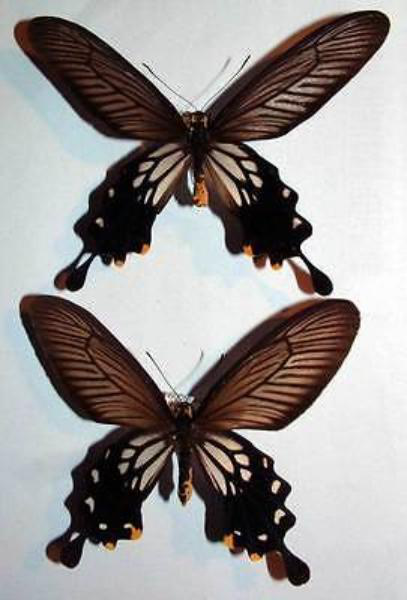

In [21]:
from PIL import Image
# site = 255  # 读取图片位置
model_state_dict = paddle.load('./butterfly.pdparams')  # 读取模型
model = MyCNN()  # 实例化模型
model.set_state_dict(model_state_dict) 
model.eval()

img = load_image(index)

print(paddle.to_tensor(img).shape)
# print(paddle.reshape(paddle.to_tensor(img), (1, 3, 224, 224)))
ceshi = model(paddle.reshape(paddle.to_tensor(img), (1, 3, 224, 224)))  # 测试
print('预测的结果为:', list(label_dic.keys())[np.argmax(ceshi.numpy())])  # 获取值

Image.open(index)  # 显示图片